In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', False)

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  

import catboost as cb

from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    classification_report, 

)
from sklearn.model_selection import StratifiedKFold ,train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

import os
import pickle
import random

In [2]:
SEED = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
set_seed(SEED)

In [3]:
class data_preprocess:
    def __init__(self, data_train, data_test, target):
        self.data_train = data_train
        self.data_test = data_test
        self.target = target
        self.median_col = [
            'pressure',
            'maxtemp',
            'temparature',
            'mintemp',
            'dewpoint'
        ]
        self.weird_col = [
            'humidity',
            'cloud',
            'sunshine',
            'windspeed'
        ]
        
    def _reduce_col(self):
        _cols = self.data_test.columns

        mean_wind_tr = (self.data_train['winddirection'].mean()).round()
        self.data_test['winddirection'].fillna(mean_wind_tr, inplace=True)

        for col in _cols:
            if self.data_train[col].dtype == 'int64':
                self.data_train[col] = self.data_train[col].astype('int32')
                self.data_test[col] = self.data_test[col].astype('int32')
            
            elif self.data_train[col].dtype == 'float64':
                self.data_train[col] = self.data_train[col].astype('float32')
                self.data_test[col] = self.data_test[col].astype('float32')

    def _extra_features(self):
        self.data_train['col_1'] = self.data_train['maxtemp'] - self.data_train['mintemp']
        self.data_test['col_1'] = self.data_test['maxtemp'] - self.data_test['mintemp']

        self.data_train['col_2'] = self.data_train['temparature'] - self.data_train['mintemp']
        self.data_test['col_2'] = self.data_test['temparature'] - self.data_test['mintemp']

        self.data_train['col_3'] = self.data_train['maxtemp'] - self.data_train['temparature']
        self.data_test['col_3'] = self.data_train['maxtemp'] - self.data_test['temparature']

        self.data_train['col_4'] = self.data_train['humidity'] - self.data_train['dewpoint']
        self.data_test['col_4'] = self.data_test['humidity'] - self.data_test['dewpoint']

        self.data_train['col_rad'] = np.deg2rad(self.data_train['winddirection'])
        self.data_train['col_5'] = self.data_train['windspeed'] * np.sin(self.data_train['col_rad']*3.14 / 180)
        self.data_train['col_6'] = self.data_train['windspeed'] * np.cos(self.data_train['col_rad']*3.14 / 180)
        self.data_train.drop(columns=['col_rad'], inplace=True)
        self.data_test['col_rad'] = np.deg2rad(self.data_test['winddirection'])
        self.data_test['col_5'] = self.data_test['windspeed'] * np.sin(self.data_test['col_rad']*3.14 / 180)
        self.data_test['col_6'] = self.data_test['windspeed'] * np.cos(self.data_test['col_rad']*3.14 / 180)
        self.data_test.drop(columns=['col_rad'], inplace=True)

        self.data_train['col_7'] = (
            35.74 + 
            (0.6215 * self.data_train['temparature']) - 
            (35.75 * (self.data_train['winddirection']**0.16)) + 
            (0.4275 * self.data_train['temparature'] * (self.data_train['winddirection']**0.16))
            )
        
        self.data_test['col_7'] = (
            35.74 + 
            (0.6215 * self.data_test['temparature']) - 
            (35.75 * (self.data_test['winddirection']**0.16)) + 
            (0.4275 * self.data_test['temparature'] * (self.data_test['winddirection']**0.16))
            )
    
    def _weird_features(self):
        _cols = self.data_test.columns

        data_filtered = self.data_train.copy()
        data_filtered = data_filtered.loc[data_filtered['rainfall'] == 0]

        for m_col in self.median_col:
            f_name = f'median_diff_{m_col}'
            val = data_filtered[m_col].mean()
            self.data_train[f_name] = self.data_train[m_col] - val
            self.data_test[f_name] = self.data_test[m_col] - val
        
        w_columns = []
        for w_col in self.weird_col:
            cat_val_1 = self.data_train[self.data_train[self.target] == 1][w_col]
            cat_val_2 = self.data_train[self.data_train[self.target] == 0][w_col]
            
            kde_1 = gaussian_kde(cat_val_1)
            kde_2 = gaussian_kde(cat_val_2)
            
            x_1 = np.linspace(min(cat_val_1), max(cat_val_1), 500)  
            y_1 = kde_1(x_1)
            max_val_in_1 = np.argmax(y_1)
            max_val_1 = x_1[max_val_in_1]
            
            x_2 = np.linspace(min(cat_val_2), max(cat_val_2), 500)
            y_2 = kde_2(x_2)
            max_val_in_2 = np.argmax(y_2)
            max_val_2 = x_2[max_val_in_2]
            
            mean_v = (max_val_1 + max_val_2) / 2
           
            col_name = f'cat_{w_col}'
            w_columns.append(col_name)
            self.data_train[col_name] = self.data_train[w_col].apply(lambda x: 1 if x >= mean_v else 0)
            self.data_test[col_name] = self.data_test[w_col].apply(lambda x: 1 if x >= mean_v else 0)
            
        self.data_train['bit_col'] = self.data_train[w_columns].apply(lambda x: ''.join(x.astype(str)), axis=1)
        self.data_test['bit_col'] = self.data_test[w_columns].apply(lambda x: ''.join(x.astype(str)), axis=1)
        self.data_train['dec_col'] = self.data_train['bit_col'].apply(lambda x: int(x,2))
        self.data_test['dec_col'] = self.data_test['bit_col'].apply(lambda x: int(x,2))
        self.data_train.drop(columns=['bit_col'], inplace=True)
        self.data_test.drop(columns=['bit_col'], inplace=True)

    def _process(self):
        self._reduce_col()
        self._extra_features()
        self._weird_features()

        return self.data_train, self.data_test

In [4]:
class CatBoostModel:
    def __init__(self, objective='Logloss', eval_metric='AUC', task_type = 'CPU', n_trials=100):
        self.objective = objective  
        self.eval_metric = eval_metric  
        self.n_trials = n_trials
        self.device_type = task_type
        self.best_params = None
        self.model = None
        self.history = None
        self.best_iteration = None

    def objective_function(self, trial, X_train, y_train, X_val, y_val):
        params = {
            'objective': self.objective,  
            'eval_metric': self.eval_metric,  
            'loss_function': self.objective,  
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 1.0, log=True),
            'random_seed': 42,
            'task_type': self.device_type,
            'verbose': False,
            'early_stopping_rounds': 50  
        }

        model = cb.CatBoostClassifier(**params) 
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

        preds_proba = model.predict_proba(X_val)[:, 1]  
        score = roc_auc_score(y_val, preds_proba)
        return score

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val):
        study = optuna.create_study(direction='maximize') 
        study.optimize(lambda trial: self.objective_function(trial, X_train, y_train, X_val, y_val),
                       n_trials=self.n_trials)

        self.best_params = study.best_params
        print(f"Best parameters: {self.best_params}")

    def train(self, X_train, y_train, X_val=None, y_val=None):
        if self.best_params is None:
            raise ValueError('You must optimize hyperparameters first.')

        params = self.best_params.copy()
        params['objective'] = self.objective 
        params['eval_metric'] = self.eval_metric  
        params['loss_function'] = self.objective  
        params['random_seed'] = 42
        params['verbose'] = False

        self.model = cb.CatBoostClassifier(**params)

        if X_val is not None and y_val is not None:
            self.model.fit(X_train, y_train,
                           eval_set=[(X_val, y_val)],
                           verbose=False,
                           plot=False)
            self.history = self.model.get_evals_result()
            self.best_iteration = self.model.get_best_iteration()
        else:
            self.model.fit(X_train, y_train, verbose=False)
            self.history = None
            self.best_iteration = None

    def plot_training_history(self):
        if self.history is None:
            print('Training history is not available. Please train with validation data.')
            return

        print('Educational background structure:', self.history.keys())

        metric = self.eval_metric

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['validation'][metric], label=f'Validation ({metric})')

        if self.best_iteration is not None:
            plt.axvline(self.best_iteration, color='red', linestyle='--', label=f'Best Iteration ({self.best_iteration})')
        plt.xlabel('Trails')
        plt.ylabel(metric.upper())
        plt.title(f'CatBoost Training History ({metric})')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, X):
        if self.model is None:
            raise ValueError('You must train the model first.')
        return self.model.predict(X)

    def predict_proba(self, X): 
        if self.model is None:
            raise ValueError('You must train the model first.')
        return self.model.predict_proba(X)

    def save_model(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.model, f)
        print(f"Model saved to: {filepath}")

    def load_model(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")

        with open(filepath, 'rb') as f:
            self.model = pickle.load(f)
        print(f"Model loaded from: {filepath}")

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("You must train the model first.")

        preds = self.predict(X_test)
        preds_proba = self.predict_proba(X_test)[:, 1] 

        accuracy = accuracy_score(y_test, preds)
        report = classification_report(y_test, preds)
        auc = roc_auc_score(y_test, preds_proba)

        print(f"Accuracy: {accuracy}")
        print("Classification Report:\n", report)
        print(f"AUC: {auc}")
        return auc, accuracy

In [5]:
class LogisticRegressionModel:
    def __init__(self, n_trials=100):
        self.n_trials = n_trials
        self.best_params = None
        self.model = None
        self.history = None
        self.best_iteration = None
        self.scaler = None  

    def objective_function(self, trial, X_train, y_train, X_val, y_val):
        C = trial.suggest_float("C", 1e-5, 1e5, log=True) 
        solver = trial.suggest_categorical("solver", ["liblinear", "saga", "newton-cg"])  
        
        if solver == "newton-cg":
          penalty = "l2"
        else:
          penalty = trial.suggest_categorical("penalty", ["l1", "l2"])  

        model = LogisticRegression(C=C, solver=solver, penalty=penalty, random_state=42, max_iter=100)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_pred_proba)

        return roc_auc  

    def optimize_hyperparameters(self, X_train, y_train, X_val, y_val):
        study = optuna.create_study(direction='maximize') 
        study.optimize(lambda trial: self.objective_function(trial, X_train, y_train, X_val, y_val),
                       n_trials=self.n_trials)

        self.best_params = study.best_params
        print(f"Best parameters: {self.best_params}")

    def train(self, X_train, y_train, X_val=None, y_val=None):
        if self.best_params is None:
            raise ValueError('You must optimize hyperparameters first.')

        self.model = LogisticRegression(**self.best_params, random_state=42, max_iter=100)

        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train)
        self.model.fit(X_train, y_train)
        self.history = None
        self.best_iteration = None

    def predict(self, X):
        if self.model is None:
            raise ValueError('You must train the model first.')
        X = self.scaler.transform(X)
        return self.model.predict(X)

    def predict_proba(self, X):
        if self.model is None:
            raise ValueError('You must train the model first.')
        X = self.scaler.transform(X)
        return self.model.predict_proba(X)

    def save_model(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self, f)  
        print(f"Model saved to: {filepath}")

    def load_model(self, filepath):
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Model file not found: {filepath}")

        with open(filepath, 'rb') as f:
            loaded = pickle.load(f)
            self.model = loaded.model
            self.scaler = loaded.scaler 
        print(f"Model loaded from: {filepath}")

    def evaluate(self, X_test, y_test):
        if self.model is None:
            raise ValueError("You must train the model first.")

        X_test = self.scaler.transform(X_test)
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)[:, 1]  
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC AUC: {roc_auc}")
        return roc_auc, None

In [6]:
def stratified_kfold_cross_validation(X, y, model, n_splits=5):  
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  
    auc_scores = []
    acc_scores = []
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")  

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.optimize_hyperparameters(X_train, y_train, X_val, y_val) 
        model.train(X_train, y_train, X_val, y_val)
        #model.plot_training_history()
        auc, acc = model.evaluate(X_val, y_val) 
        auc_scores.append(auc)
        acc_scores.append(acc)
        model.save_model(f"/kaggle/working/catboost_model_{fold + 1}.pkl")

    print(f"AUC Mean: {np.mean(auc_scores)}")
    print(f"AUC Scores: {auc_scores}")
    
    max_index, max_value = max(enumerate(auc_scores), key=lambda x: x[1])
    return max_index, acc_scores

In [7]:
def stratified_kfold_cross_validation_2(X, y, model, n_splits=5):  
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  
    auc_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")  

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.optimize_hyperparameters(X_train, y_train, X_val, y_val)
        model.train(X_train, y_train)
        auc, acc = model.evaluate(X_val, y_val)
        model.save_model(f'/kaggle/working/logistic_regression_model_{fold + 1}.pkl')
        auc_scores.append(auc)

    print(f"AUC Mean: {np.mean(auc_scores)}")
    print(f"AUC Scores: {auc_scores}")
    
    max_index, max_value = max(enumerate(auc_scores), key=lambda x: x[1])
    return max_index

In [8]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [9]:
df_train = df_train.drop(columns=['id', 'day'])
df_test_id = df_test['id']
df_test = df_test.drop(columns=['id', 'day',])
df_train_y = df_train['rainfall']

In [10]:
df_train, df_test = data_preprocess(df_train, df_test,'rainfall')._process()
df_train = df_train.drop(columns=['rainfall'])

In [11]:
cpy_tr = df_train.copy()
cat_lin_tr = cpy_tr.drop(columns=['dec_col'])
cpy_te = df_test.copy()
cat_lin_te = cpy_te.drop(columns=['dec_col'])

In [12]:
mlp_tr = df_train.drop(columns=['cat_humidity', 'cat_cloud', 'cat_sunshine', 'cat_windspeed'])
mlp_te = df_test.drop(columns=['cat_humidity', 'cat_cloud', 'cat_sunshine', 'cat_windspeed'])

In [13]:
scaler = StandardScaler()
cat_lin_tr = scaler.fit_transform(cat_lin_tr)
cat_lin_te = scaler.transform(cat_lin_te)

df_train_y = pd.Series(df_train_y)

In [14]:
%%time
catboost_model = CatBoostModel(objective='Logloss', eval_metric='AUC', task_type='CPU', n_trials=200)
auc_num, max_acc = stratified_kfold_cross_validation(cat_lin_tr, df_train_y, catboost_model, n_splits=10)

Fold 1/10
Best parameters: {'iterations': 779, 'learning_rate': 0.0926217132260029, 'depth': 5, 'l2_leaf_reg': 2.3286900206102864e-07}
Accuracy: 0.8904109589041096
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77        54
           1       0.92      0.93      0.93       165

    accuracy                           0.89       219
   macro avg       0.86      0.85      0.85       219
weighted avg       0.89      0.89      0.89       219

AUC: 0.915151515151515
Model saved to: /kaggle/working/catboost_model_1.pkl
Fold 2/10
Best parameters: {'iterations': 854, 'learning_rate': 0.07953061196893552, 'depth': 4, 'l2_leaf_reg': 4.644879907704908e-07}
Accuracy: 0.9269406392694064
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.80      0.84        54
           1       0.94      0.97      0.95       165

    accuracy                           0.93       219
   

In [15]:
%%time
model = LogisticRegressionModel(n_trials=200)
auc_num_li = stratified_kfold_cross_validation_2(cat_lin_tr, df_train_y, model, n_splits=10)

Fold 1/10
Best parameters: {'C': 0.015308432409689344, 'solver': 'newton-cg'}
ROC AUC: 0.8900112233445566
Model saved to: /kaggle/working/logistic_regression_model_1.pkl
Fold 2/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.11545233596164559, 'solver': 'liblinear', 'penalty': 'l1'}
ROC AUC: 0.9567901234567902
Model saved to: /kaggle/working/logistic_regression_model_2.pkl
Fold 3/10
Best parameters: {'C': 0.001107249883834535, 'solver': 'newton-cg'}
ROC AUC: 0.8905723905723906
Model saved to: /kaggle/working/logistic_regression_model_3.pkl
Fold 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.045784371669716585, 'solver': 'saga', 'penalty': 'l1'}
ROC AUC: 0.8327721661054995
Model saved to: /kaggle/working/logistic_regression_model_4.pkl
Fold 5/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters: {'C': 2.1870080509660963, 'solver': 'liblinear', 'penalty': 'l2'}
ROC AUC: 0.8823793490460157
Model saved to: /kaggle/working/logistic_regression_model_5.pkl
Fold 6/10
Best parameters: {'C': 0.014467440059857969, 'solver': 'saga', 'penalty': 'l2'}
ROC AUC: 0.8901234567901234
Model saved to: /kaggle/working/logistic_regression_model_6.pkl
Fold 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 79050.56355812351, 'solver': 'newton-cg'}
ROC AUC: 0.9093153759820426
Model saved to: /kaggle/working/logistic_regression_model_7.pkl
Fold 8/10
Best parameters: {'C': 99989.38156412655, 'solver': 'newton-cg'}
ROC AUC: 0.9161616161616162
Model saved to: /kaggle/working/logistic_regression_model_8.pkl
Fold 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.03256812575145203, 'solver': 'liblinear', 'penalty': 'l1'}
ROC AUC: 0.9151515151515152
Model saved to: /kaggle/working/logistic_regression_model_9.pkl
Fold 10/10


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 0.0036080974835774166, 'solver': 'newton-cg'}
ROC AUC: 0.8884399551066218
Model saved to: /kaggle/working/logistic_regression_model_10.pkl
AUC Mean: 0.8971717171717172
AUC Scores: [0.8900112233445566, 0.9567901234567902, 0.8905723905723906, 0.8327721661054995, 0.8823793490460157, 0.8901234567901234, 0.9093153759820426, 0.9161616161616162, 0.9151515151515152, 0.8884399551066218]
CPU times: user 1min 22s, sys: 481 ms, total: 1min 22s
Wall time: 1min 3s


In [16]:
loaded_cat_model = CatBoostModel()
cat_name = f'/kaggle/working/catboost_model_{auc_num + 1}.pkl'
loaded_cat_model.load_model(cat_name)
predictions_cat = loaded_cat_model.predict(cat_lin_te)
probabilities_cat = loaded_cat_model.predict_proba(cat_lin_te)[:, 1]

Model loaded from: /kaggle/working/catboost_model_2.pkl


In [17]:
loaded_model_lin = LogisticRegressionModel()
loaded_model_lin.load_model(f'/kaggle/working/logistic_regression_model_{auc_num_li + 1}.pkl')
probabilities_lin = loaded_model_lin.predict_proba(cat_lin_te)[:,1]

Model loaded from: /kaggle/working/logistic_regression_model_2.pkl


In [18]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)  
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [19]:
def objective(trial, X_train, X_val, y_train, y_val):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_size = trial.suggest_int('hidden_size', 20, 100)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 200)

    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    


    class MLP(nn.Module):
        def __init__(self, input_size, hidden_size, dropout_rate=0.5):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout_rate)  
            self.fc2 = nn.Linear(hidden_size, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.dropout(out)  
            out = self.fc2(out)
            out = self.sigmoid(out)
            return out
    
    input_size = X_train.shape[1]
    model = MLP(input_size, hidden_size, dropout_rate)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1)) 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
            optimizer.step()
            epoch_loss += loss.item()  

            predicted = (outputs > 0.5).float()  
            correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()
            total_samples += labels.size(0)

            #if (i + 1) % 10 == 0:
            #    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #          .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

        epoch_loss /= len(train_loader)
        epoch_accuracy = correct_predictions / total_samples

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        #print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}'
        #      .format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))
    
    with torch.no_grad():
        outputs = model(X_val)
        predicted_probs = outputs.cpu().numpy() 
        auc = roc_auc_score(y_val.cpu().numpy(), predicted_probs) 
        #print('Test AUC: {:.4f}'.format(auc))
    '''
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    '''
    return auc

In [20]:
def run_optuna_mlp(X_train, X_val, y_train, y_val, n_trials=200):
    def lambda_objective(trial):
        return objective(trial, X_train, X_val, y_train, y_val)
        
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda_objective, n_trials=n_trials)

    print("Best Trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return study.best_params

In [21]:
X_train, X_val, y_train, y_val = train_test_split(mlp_tr, df_train_y, test_size=0.2, random_state=SEED)

In [22]:
best_params_mlp = run_optuna_mlp(X_train, X_val, y_train, y_val, n_trials=200)

Best Trial:
  Value: 0.8788230025552541
  Params: 
    lr: 0.0011085555225503467
    hidden_size: 69
    dropout_rate: 0.08113795388780992
    batch_size: 32
    num_epochs: 126


Epoch [1/126], Step [10/55], Loss: 18.7500
Epoch [1/126], Step [20/55], Loss: 15.8481
Epoch [1/126], Step [30/55], Loss: 31.2500
Epoch [1/126], Step [40/55], Loss: 12.5000
Epoch [1/126], Step [50/55], Loss: 28.1250
Epoch [1/126], Train Loss: 22.5760, Train Accuracy: 0.7437
Epoch [2/126], Step [10/55], Loss: 21.8750
Epoch [2/126], Step [20/55], Loss: 13.6474
Epoch [2/126], Step [30/55], Loss: 7.0909
Epoch [2/126], Step [40/55], Loss: 19.6926
Epoch [2/126], Step [50/55], Loss: 22.3087
Epoch [2/126], Train Loss: 17.2489, Train Accuracy: 0.7009
Epoch [3/126], Step [10/55], Loss: 8.1791
Epoch [3/126], Step [20/55], Loss: 9.0024
Epoch [3/126], Step [30/55], Loss: 14.2375
Epoch [3/126], Step [40/55], Loss: 8.6198
Epoch [3/126], Step [50/55], Loss: 13.3741
Epoch [3/126], Train Loss: 8.3764, Train Accuracy: 0.7078
Epoch [4/126], Step [10/55], Loss: 9.4134
Epoch [4/126], Step [20/55], Loss: 4.2673
Epoch [4/126], Step [30/55], Loss: 1.2066
Epoch [4/126], Step [40/55], Loss: 4.9406
Epoch [4/126], 

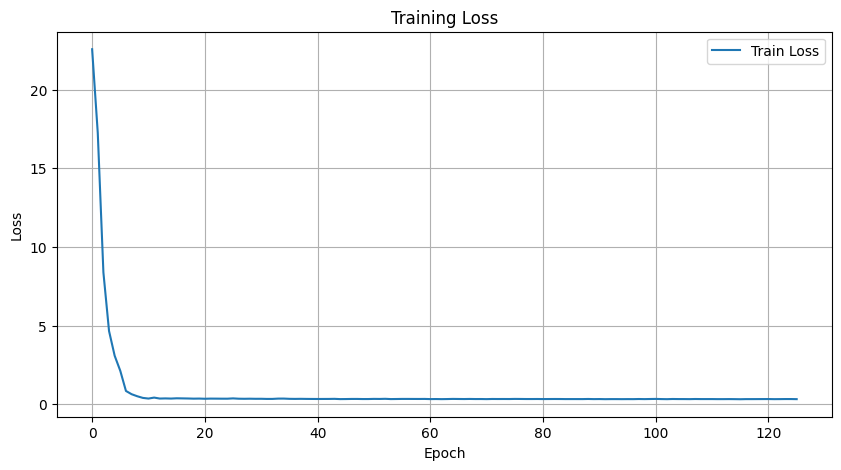

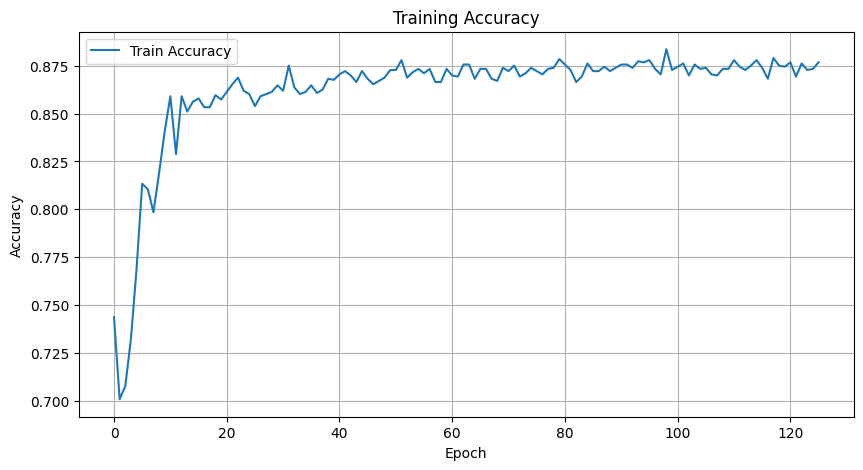

In [23]:
input_size = mlp_tr.shape[1]
hidden_size = best_params_mlp['hidden_size']

model_mlp = MLP(input_size, hidden_size=best_params_mlp['hidden_size'], dropout_rate= best_params_mlp['dropout_rate'])

X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=best_params_mlp['batch_size'], shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=best_params_mlp['lr'])

num_epochs = best_params_mlp['num_epochs']
batch_size = best_params_mlp['batch_size']

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels.unsqueeze(1)) 

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_mlp.parameters(), max_norm=1.0) 
        optimizer.step()

        epoch_loss += loss.item()  
        predicted = (outputs > 0.5).float() 
        correct_predictions += (predicted == labels.unsqueeze(1)).sum().item()
        total_samples += labels.size(0)

        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))

    epoch_loss /= len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}'
          .format(epoch + 1, num_epochs, epoch_loss, epoch_accuracy))

with torch.no_grad():
    outputs = model_mlp(X_val)
    predicted_probs = outputs.cpu().numpy()
    
    auc = roc_auc_score(y_val.cpu().numpy(), predicted_probs) 
    print('Test AUC: {:.4f}'.format(auc))

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
PATH = "/kaggle/working/mlp_model_state.pth"
torch.save(model_mlp.state_dict(), PATH)
print('The models state dictionary has been saved.: {}'.format(PATH))

model_mlp_pred = MLP(input_size, hidden_size)
model_mlp_pred.load_state_dict(torch.load(PATH))
model_mlp_pred.eval()  
print("The model's state dictionary has been loaded.: {}".format(PATH))

test_tensor = torch.tensor(mlp_te.to_numpy(), dtype=torch.float32)

with torch.no_grad():
    outputs = model_mlp_pred(test_tensor)
    predicted_probs_mlp = outputs.cpu().numpy()  

The models state dictionary has been saved.: /kaggle/working/mlp_model_state.pth
The model's state dictionary has been loaded.: /kaggle/working/mlp_model_state.pth


In [25]:
def sum_pred(pred_1, pred_2):
    return (pred_1 + pred_2) / 2

def sum_pred_2(pred_1, pred_2, pred_3):
    return (pred_1 + pred_2 + pred_3) / 3

In [26]:
sub_1 = sum_pred(predicted_probs_mlp, probabilities_lin)
sub_2 = sum_pred(probabilities_cat, probabilities_lin)
sub_3 = sum_pred_2(predicted_probs_mlp, probabilities_lin, probabilities_cat)

In [27]:
output = pd.DataFrame({
    'id': df_test_id, 
    'rainfall': sub_3[:,0]
})

output

,id,rainfall
0,2190,0.980159
1,2191,0.982818
2,2192,0.979244
3,2193,0.654192
4,2194,0.654057
...,...,...
725,2915,0.976426
726,2916,0.908593
727,2917,0.972141
728,2918,0.982242


In [28]:
"""
output = pd.DataFrame({
    'id': df_test_id, 
    'rainfall': sub_2[:,0]
})

output
"""

"\noutput = pd.DataFrame({\n    'id': df_test_id, \n    'rainfall': sub_2[:,0]\n})\n\noutput\n"

In [29]:
"""
output = pd.DataFrame({
    'id': df_test_id, 
    'rainfall': sub_3[:,0]
})

output
"""

"\noutput = pd.DataFrame({\n    'id': df_test_id, \n    'rainfall': sub_3[:,0]\n})\n\noutput\n"

In [30]:
output.to_csv('submission.csv', index=False)